# Train a model

In this tutorial we will use TensorFlow to train a model.

In [1]:
import sys
import platform
import os
print("Python version: {}".format(sys.version))
print("{}".format(platform.platform()))

Python version: 3.10.8 (main, Nov 24 2022, 14:13:03) [GCC 11.2.0]
Linux-5.19.0-051900-generic-x86_64-with-glibc2.35


# Biomedical Image Segmentation with U-Net

In this code example, we apply the U-Net architecture to segment brain tumors from raw MRI scans as shown below. With relatively little data we are able to train a U-Net model to accurately predict where tumors exist. 

The Dice coefficient (the standard metric for the BraTS dataset used in the study) for our model is about 0.82-0.88.  Menze et al. [reported](http://ieeexplore.ieee.org/document/6975210/) that expert neuroradiologists manually segmented these tumors with a cross-rater Dice score of 0.75-0.85, meaning that the model’s predictions are on par with what expert physicians have made.

<img src="images/figure1.png">

Since its introduction two years ago, the [U-Net](https://arxiv.org/pdf/1505.04597.pdf0) architecture has been used to create deep learning models for segmenting [nerves](https://github.com/jocicmarko/ultrasound-nerve-segmentation) in ultrasound images, [lungs](https://www.kaggle.com/c/data-science-bowl-2017#tutorial) in CT scans, and even [interference](https://github.com/jakeret/tf_unet) in radio telescopes.

## What is U-Net?
U-Net is designed like an [auto-encoder](https://en.wikipedia.org/wiki/Autoencoder). It has an encoding path (“contracting”) paired with a decoding path (“expanding”) which gives it the “U” shape.  However, in contrast to the autoencoder, U-Net predicts a pixelwise segmentation map of the input image rather than classifying the input image as a whole. For each pixel in the original image, it asks the question: “To which class does this pixel belong?” This flexibility allows U-Net to predict different parts of the tumor simultaneously.

<img src="images/unet.png">

This module loads the data generator from `dataloader.py`, creates a TensorFlow/Keras model from `model.py`, trains the model on the data, and then saves the best model.

### TensorFlow Version Check

Check to see what version of TensorFlow is installed and if it has [Intel DNNL optimizations](https://software.intel.com/content/www/us/en/develop/articles/intel-optimization-for-tensorflow-installation-guide.html)

In [2]:
def test_oneDNN():
    import tensorflow as tf

    import os

    def get_mkl_enabled_flag():

        mkl_enabled = False
        major_version = int(tf.__version__.split(".")[0])
        minor_version = int(tf.__version__.split(".")[1])
        if major_version >= 2:
            if minor_version < 5:
                from tensorflow.python import _pywrap_util_port
            elif minor_version >= 9:

                from tensorflow.python.util import _pywrap_util_port
                onednn_enabled = int(os.environ.get('TF_ENABLE_ONEDNN_OPTS', '1'))

            else:
                from tensorflow.python.util import _pywrap_util_port
                onednn_enabled = int(os.environ.get('TF_ENABLE_ONEDNN_OPTS', '0'))
            mkl_enabled = _pywrap_util_port.IsMklEnabled() or (onednn_enabled == 1)
        else:
            mkl_enabled = tf.pywrap_tensorflow.IsMklEnabled()
        return mkl_enabled

    print ("We are using Tensorflow version", tf.__version__)
    print("oneDNN enabled :", get_mkl_enabled_flag())
test_oneDNN()   

2023-01-20 04:02:01.149702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-20 04:02:01.311066: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-20 04:02:01.317834: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-20 04:02:01.317849: I tensorflow/stream_executor/cuda/cuda

We are using Tensorflow version 2.10.0
oneDNN enabled : True


<b><font size ="5"> Enable Advanced AMP </font>

In [3]:
def set_itex_amp(amp_target, device):
    # set configure for auto mixed precision.
    import intel_extension_for_tensorflow as itex
    print("intel_extension_for_tensorflow {}".format(itex.__version__))

    auto_mixed_precision_options = itex.AutoMixedPrecisionOptions()
    if amp_target=="BF16":
        auto_mixed_precision_options.data_type = itex.BFLOAT16
    else:
        auto_mixed_precision_options.data_type = itex.FLOAT16

    graph_options = itex.GraphOptions(auto_mixed_precision_options=auto_mixed_precision_options)
    # enable auto mixed precision.
    graph_options.auto_mixed_precision = itex.ON

    config = itex.ConfigProto(graph_options=graph_options)
    # set GPU backend.
    print(config)
    backend = device
    itex.set_backend(backend, config)

    print("Set itex for AMP (auto_mixed_precision, {}_FP32) with backend {}".format(amp_target, backend))


intel_extension_for_tensorflow 1.0.0
graph_options {
  auto_mixed_precision: ON
  auto_mixed_precision_options {
    data_type: BFLOAT16
  }
}

Set itex for AMP (auto_mixed_precision, BF16_FP32) with backend cpu


<font size = "5">Setting OpenMP environment variables to parallelize deep learning model execution among CPU cores.</font>

In [ ]:
enable_amp = True
enable_OMP_settings = True

if enable_OMP_settings:
    # If hyperthreading is enabled, then use
    os.environ["KMP_AFFINITY"] = "granularity=thread,compact,1,0"

    # If hyperthreading is NOT enabled, then use
    #os.environ["KMP_AFFINITY"] = "granularity=thread,compact"

    os.environ["KMP_BLOCKTIME"] = str(settings.blocktime)
    os.environ["OMP_NUM_THREADS"] = str(settings.NUM_INTRA_THREADS)
    os.environ["KMP_SETTINGS"] = "0"  # Show the settings at runtime

else 
    os.environ["INTRA_THREADS"] = str(settings.NUM_INTRA_THREADS)
    os.environ["INTER_THREADS"] = str(settings.NUM_INTER_THREADS)



#setting BF16 Auto mixed precision   
if enable_amp:
    device = "cpu"
    amp_target = "BF16"
    set_itex_amp( amp_target, device )  
    settings.INFERENCE_FILENAME = "2d_unet_decathlon_bf16"

## Training Time!

The bulk of the training section can be broken down in 4 simple steps:
1. Load the training data
1. Define the model
3. Train the model on the data
4. Evaluate the best model
    

#### Step 1 : Loading the BraTS data set from the tf.data loader

In [4]:
data_path = "../Task01_BrainTumour/"

crop_dim=128  # Original resolution (240)
batch_size = 128
seed=816
train_test_split=0.85

In [5]:
from dataloader import DatasetGenerator, get_decathlon_filelist

trainFiles, validateFiles, testFiles = get_decathlon_filelist(data_path=data_path, seed=seed, split=train_test_split)

ds_train = DatasetGenerator(trainFiles, 
                            batch_size=batch_size, 
                            crop_dim=[crop_dim, crop_dim], 
                            augment=True, seed=seed)

ds_validation = DatasetGenerator(validateFiles, 
                                 batch_size=batch_size, 
                                 crop_dim=[crop_dim, crop_dim], 
                                 augment=False, 
                                 seed=seed)
    
ds_test = DatasetGenerator(testFiles, 
                           batch_size=batch_size, 
                           crop_dim=[crop_dim, crop_dim], 
                           augment=False, 
                           seed=seed)


******************************
Dataset name:         BRATS
Dataset description:  Gliomas segmentation tumour and oedema in on brain images
Tensor image size:    4D
Dataset release:      2.0 04/05/2018
Dataset reference:    https://www.med.upenn.edu/sbia/brats2017.html
Dataset license:      CC-BY-SA 4.0
******************************
Number of training files   = 411
Number of validation files = 36
Number of testing files    = 37


## Plot some samples of the dataset

We can use the DatasetGenerator's plot_samples function to plot a few samples of the dataset. Note that with `augment` set to True, we have randomly cropped, flipped, and rotated the images.

(128, 128, 128, 1)


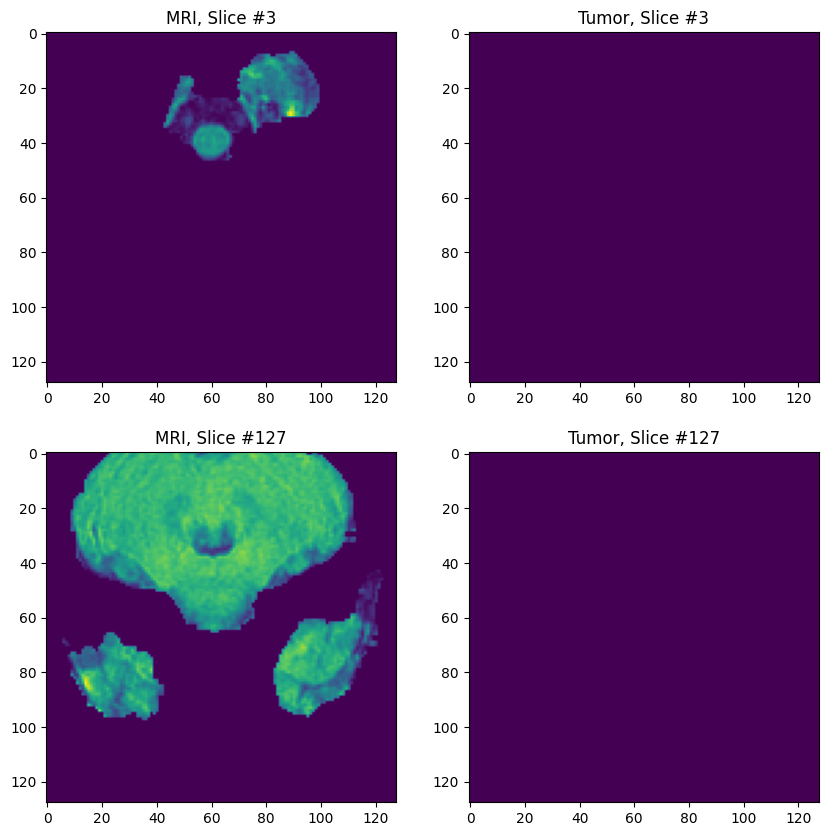

In [7]:
ds_train.plot_samples()

(128, 128, 128, 1)


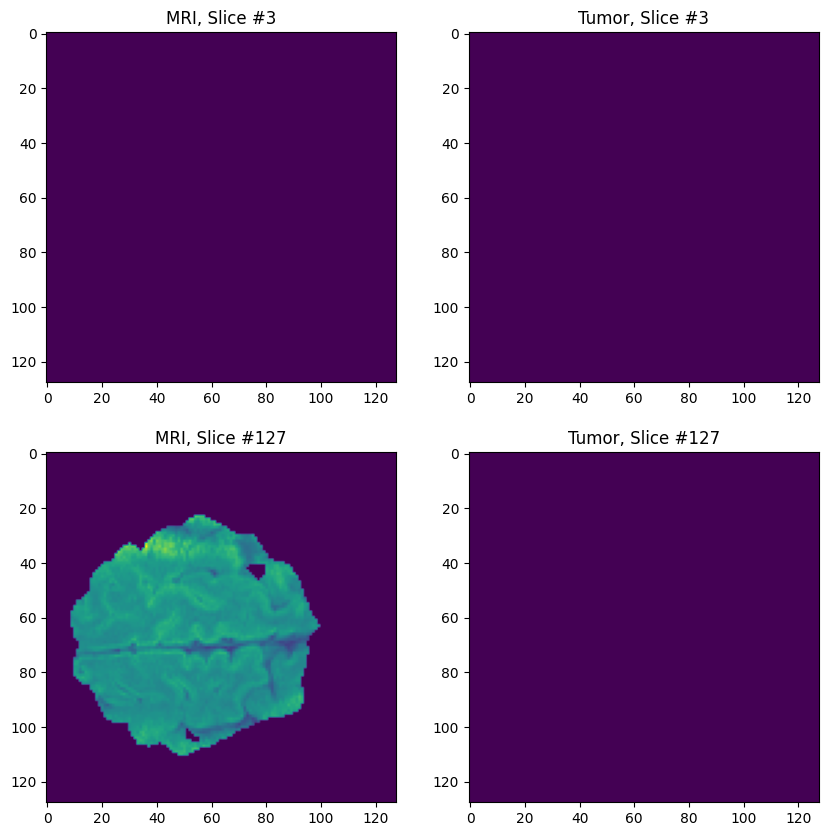

In [8]:
ds_validation.plot_samples()

#### Step 2: Define the model

In [6]:
from model import unet

print("-" * 30)
print("Creating and compiling model ...")
print("-" * 30)

unet_model = unet(fms=8, learning_rate=1e-4, use_dropout=False, use_upsampling=False)

model = unet_model.create_model(
        ds_train.get_input_shape(), 
        ds_train.get_output_shape())

model_filename, model_callbacks = unet_model.get_callbacks()

# # If there is a current saved file, then load weights and start from there.
# saved_model = os.path.join(args.output_path, args.inference_filename)
# if os.path.isfile(saved_model):
#     model.load_weights(saved_model)

------------------------------
Creating and compiling model ...
------------------------------
Data format = channels_last
Using Transposed Convolution


/home/nazneen/miniconda3/envs/itex-tf/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2023-01-20 04:02:22.272085: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "2DUNet_Brats_Decathlon"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 MRImages (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 encodeAa (Conv2D)              (None, 128, 128, 8)  80          ['MRImages[0][0]']               
                                                                                                  
 encodeAb (Conv2D)              (None, 128, 128, 8)  584         ['encodeAa[0][0]']               
                                                                                                  
 poolA (MaxPooling2D)           (None, 64, 64, 8)    0           ['encodeAb[0

The code snippet below draws the model using Keras' built-in `plot_model`. Compare with the implementation of `model.py`

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


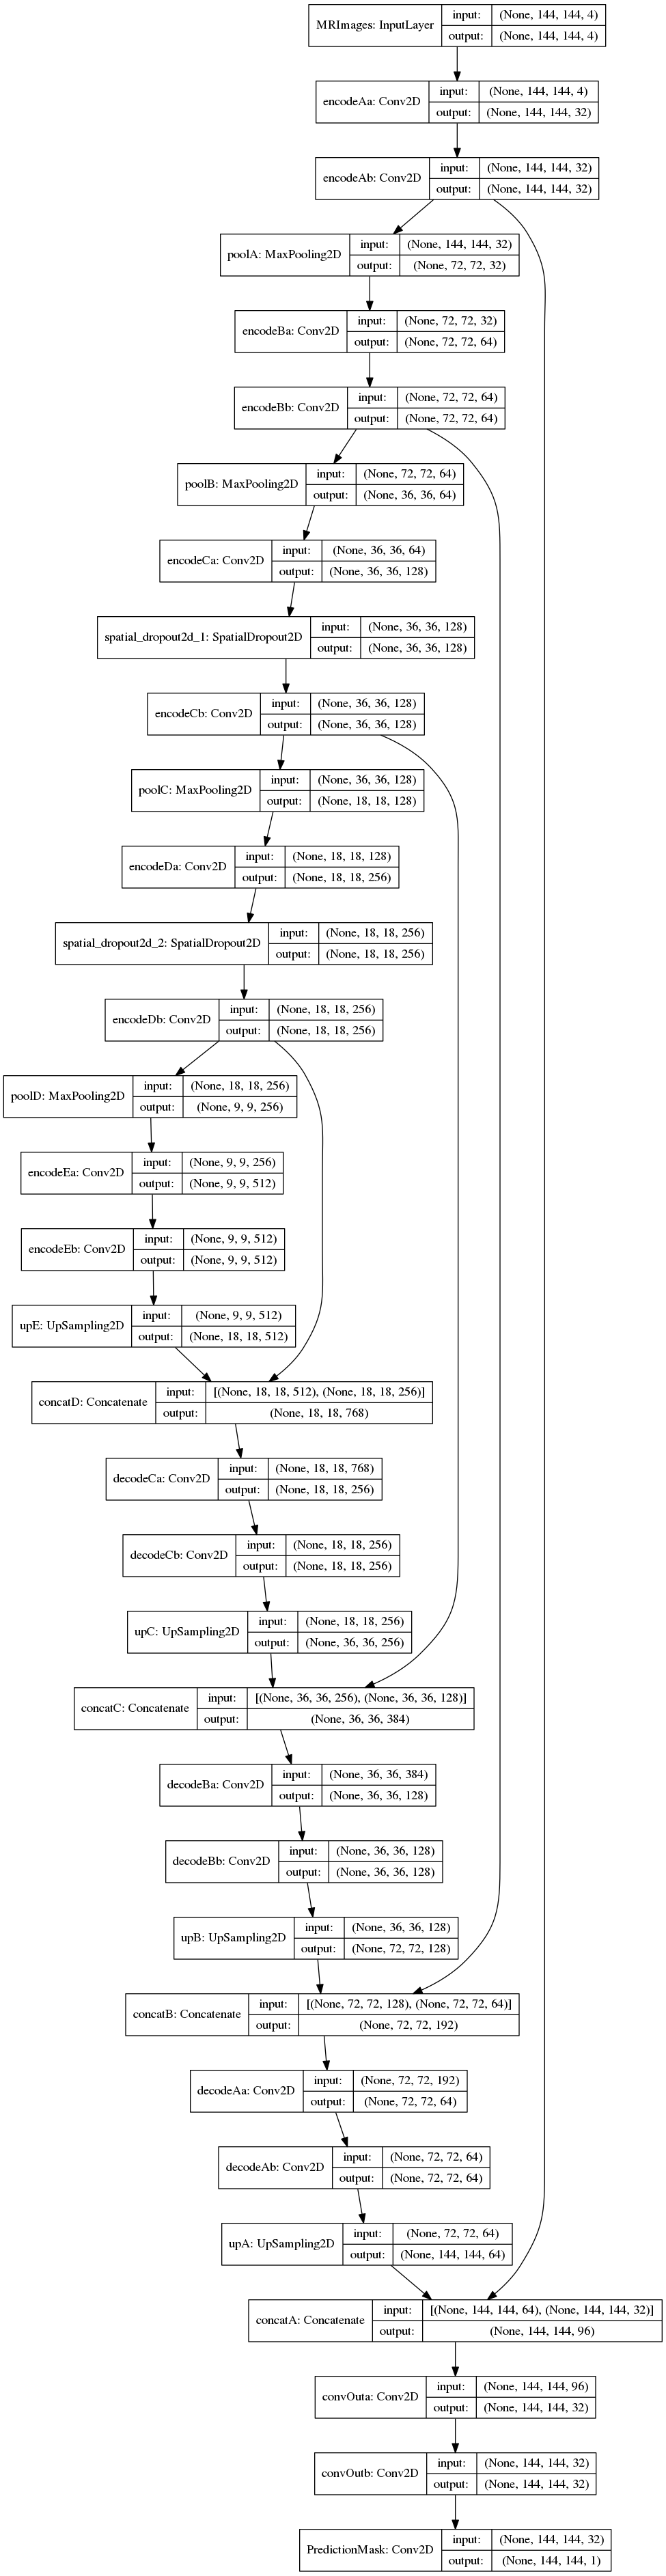

In [10]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model,
           to_file='images/model.png',
           show_shapes=True,
           show_layer_names=True,
           rankdir='TB'
            )
Image('images/model.png')

#### Step 3: Train the model on the data

In [7]:
import datetime

start_time = datetime.datetime.now()
print("Training started at {}".format(start_time))

n_epoch = 2  # Train for this many epochs

history = model.fit(ds_train,
              epochs=n_epoch,
              validation_data=ds_validation,
              verbose=1,
              callbacks=model_callbacks)

print("Total time elapsed for training = {} seconds".format(datetime.datetime.now() - start_time))
print("Training finished at {}".format(datetime.datetime.now()))
    
# Append training log
# with open("training.log","a+") as fp:
#     fp.write("{}: {}\n".format(datetime.datetime.now(),
#                              history.history["val_dice_coef"]))

Training started at 2023-01-20 04:02:31.781654
Epoch 1/2


2023-01-20 04:02:32.682495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-01-20 04:02:32.685988: I itex/core/graph/auto_mixed_precision/auto_mixed_precision.cc:109] Run advanced auto mixed precision datatype BFLOAT16 on CPU
2023-01-20 04:02:32.686626: I itex/core/graph/auto_mixed_precision/auto_mixed_precision.cc:1069] No allowlist ops found, nothing to do
2023-01-20 04:02:32.704581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-01-20 04:02:32.707706: I itex/core/graph/auto_mixed_precision/auto_mixed_precision.cc:109] Run advanced auto mixed precision datatype BFLOAT16 on CPU
2023-01-20 04:02:32.708330: I itex/core/graph/auto_mixed_precision/auto_mixed_precision.cc:1069] No allowlist ops found, nothing to do
2023-01-20 04:02:33.989305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plug

497/497 [==============================] - ETA: 0s - loss: 1.5429 - dice_coef: 0.3018 - soft_dice_coef: 0.1376

2023-01-20 04:07:54.286695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-01-20 04:07:54.289160: I itex/core/graph/auto_mixed_precision/auto_mixed_precision.cc:109] Run advanced auto mixed precision datatype BFLOAT16 on CPU
2023-01-20 04:07:54.289618: I itex/core/graph/auto_mixed_precision/auto_mixed_precision.cc:1069] No allowlist ops found, nothing to do
2023-01-20 04:07:54.309351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-01-20 04:07:54.314964: I itex/core/graph/auto_mixed_precision/auto_mixed_precision.cc:109] Run advanced auto mixed precision datatype BFLOAT16 on CPU
2023-01-20 04:07:54.316088: I itex/core/graph/auto_mixed_precision/auto_mixed_precision.cc:1069] No allowlist ops found, nothing to do
2023-01-20 04:07:54.575138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plug


Epoch 1: val_loss improved from inf to 0.69972, saving model to ./output/2d_unet_decathlon


INFO:tensorflow:Assets written to: ./output/2d_unet_decathlon/assets


INFO:tensorflow:Assets written to: ./output/2d_unet_decathlon/assets



497/497 [==============================] - 365s 728ms/step - loss: 1.5429 - dice_coef: 0.3018 - soft_dice_coef: 0.1376 - val_loss: 0.6997 - val_dice_coef: 0.5933 - val_soft_dice_coef: 0.2473


2023-01-20 04:08:37.798473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-01-20 04:08:37.801042: I itex/core/graph/auto_mixed_precision/auto_mixed_precision.cc:109] Run advanced auto mixed precision datatype BFLOAT16 on CPU
2023-01-20 04:08:37.801502: I itex/core/graph/auto_mixed_precision/auto_mixed_precision.cc:1069] No allowlist ops found, nothing to do


Epoch 2/2


2023-01-20 04:08:37.914119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-01-20 04:08:37.918903: I itex/core/graph/auto_mixed_precision/auto_mixed_precision.cc:109] Run advanced auto mixed precision datatype BFLOAT16 on CPU
2023-01-20 04:08:37.920217: I itex/core/graph/auto_mixed_precision/auto_mixed_precision.cc:1069] No allowlist ops found, nothing to do
2023-01-20 04:08:37.930120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-01-20 04:08:37.933353: I itex/core/graph/auto_mixed_precision/auto_mixed_precision.cc:109] Run advanced auto mixed precision datatype BFLOAT16 on CPU
2023-01-20 04:08:37.934207: I itex/core/graph/auto_mixed_precision/auto_mixed_precision.cc:1069] No allowlist ops found, nothing to do
2023-01-20 04:08:37.935890: I itex/core/graph/auto_mixed_precision/auto_mixed_precision.cc:109] Run advanced a

497/497 [==============================] - ETA: 0s - loss: 0.6536 - dice_coef: 0.6372 - soft_dice_coef: 0.2353

2023-01-20 04:13:58.380373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-01-20 04:13:58.384918: I itex/core/graph/auto_mixed_precision/auto_mixed_precision.cc:109] Run advanced auto mixed precision datatype BFLOAT16 on CPU
2023-01-20 04:13:58.385599: I itex/core/graph/auto_mixed_precision/auto_mixed_precision.cc:1069] No allowlist ops found, nothing to do
2023-01-20 04:13:58.403508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-01-20 04:13:58.406683: I itex/core/graph/auto_mixed_precision/auto_mixed_precision.cc:109] Run advanced auto mixed precision datatype BFLOAT16 on CPU
2023-01-20 04:13:58.407233: I itex/core/graph/auto_mixed_precision/auto_mixed_precision.cc:1069] No allowlist ops found, nothing to do
2023-01-20 04:13:58.427106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plug


Epoch 2: val_loss improved from 0.69972 to 0.43994, saving model to ./output/2d_unet_decathlon


INFO:tensorflow:Assets written to: ./output/2d_unet_decathlon/assets


INFO:tensorflow:Assets written to: ./output/2d_unet_decathlon/assets


497/497 [==============================] - 346s 694ms/step - loss: 0.6536 - dice_coef: 0.6372 - soft_dice_coef: 0.2353 - val_loss: 0.4399 - val_dice_coef: 0.6819 - val_soft_dice_coef: 0.3100
Total time elapsed for training = 0:11:51.842846 seconds
Training finished at 2023-01-20 04:14:23.624754


#### Step 4: Evaluate the best model

In [8]:
print("-" * 30)
print("Loading the best trained model ...")
print("-" * 30)
unet_model.evaluate_model(model_filename, ds_validation)

------------------------------
Loading the best trained model ...
------------------------------
Evaluating model on test dataset. Please wait...


2023-01-20 04:16:13.241374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-01-20 04:16:13.244095: I itex/core/graph/auto_mixed_precision/auto_mixed_precision.cc:109] Run advanced auto mixed precision datatype BFLOAT16 on CPU
2023-01-20 04:16:13.244569: I itex/core/graph/auto_mixed_precision/auto_mixed_precision.cc:1069] No allowlist ops found, nothing to do
2023-01-20 04:16:13.255163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-01-20 04:16:13.257564: I itex/core/graph/auto_mixed_precision/auto_mixed_precision.cc:109] Run advanced auto mixed precision datatype BFLOAT16 on CPU
2023-01-20 04:16:13.258013: I itex/core/graph/auto_mixed_precision/auto_mixed_precision.cc:1069] No allowlist ops found, nothing to do
2023-01-20 04:16:13.488806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plug

43/43 [==============================] - 30s 694ms/step - loss: 0.5314 - dice_coef: 0.6452 - soft_dice_coef: 0.2716
Test dataset loss = 0.5314
Test dataset dice_coef = 0.6452
Test dataset soft_dice_coef = 0.2716


## End: In this tutorial, you have learnt:
* What is the U-Net model
* Comparing training times - Tensorflow DNNL vs Tensorflow (stock)
* How to tweak a series of environment variables to get better performance out of DNNL
* How to tweak a series of Tensorflow-related and neural-network specific parameters for better performance

*Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License. SPDX-License-Identifier: EPL-2.0*

*Copyright (c) 2019-2020 Intel Corporation*